In [1]:
### BAYESFACTORS.IPYNB -- plots of twins vs no-twins Bayes factors

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"

sns.set_palette('Set1',color_codes=True)

EOSDIR = './etc/'
PLTDIR = './plt/'
RESDIR = './dat/'

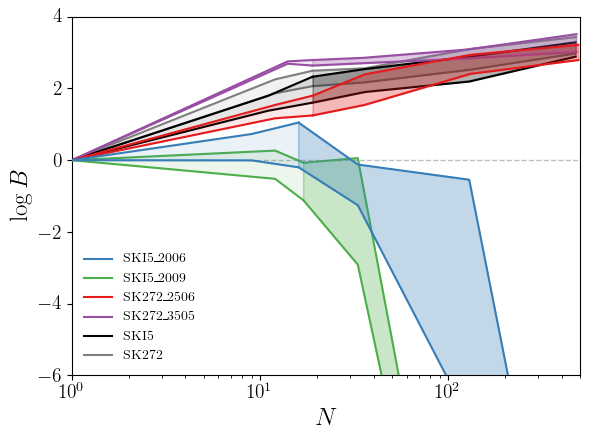

In [14]:
eoss = ['SKI52006','SKI52009','SK2722506','SK2723505','SKI5','SK272']
colors = [sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[0],sns.color_palette()[3],'k','grey']
short_scenarios = ['O5','O5','3G','3G','3G']
scenarios = ['O5','O5y2','3Gd1','3Gw1','3Gm1']
scenario_dict = {'O5': 'A+ (1 yr)', 'O5y2': 'A+ (2 yr)', '3Gd1': 'XG (1 d)', '3Gw1': 'XG (1 wk)', '3Gm1': 'XG (1 mo)'}
eos_dict = {'SKI52006': 'SKI5_2006', 'SKI52009': 'SKI5_2009', 'SK2722506': 'SK272_2506', 'SK2723505': 'SK272_3505', 'SK272': 'SK272', 'SKI5': 'SKI5'}
pops = ['v0','v2','v3','v4', 'v5','v6','v7','v8','v9']

import scipy

fig = plt.figure(figsize=(6,4.5))

for j,eos in enumerate(eoss):
    
    bfs_all = []
    
    for pop in pops:
        
        bfs = []
        events = []
        
        for short_scenario,scenario in zip(short_scenarios,scenarios):

            results_path = RESDIR+'unif_BNS_{0}{1}/{2}_unif_BNS_{0}_recovery-{3}.csv'.format(eos,pop,short_scenario,scenario)
            dat = np.genfromtxt(results_path,names=True,dtype=None,delimiter=',')
            deltaLs = dat['DeltaL']
            deltaLs = list(deltaLs) + [-dL for dL in deltaLs if dL < 50.]
            kde = scipy.stats.gaussian_kde(deltaLs)
            
            injpath = RESDIR+'unif_BNS_{0}{1}/{0}_twinstarparameters.csv'.format(eos,pop)
            inj_dat = np.genfromtxt(injpath,names=True,delimiter=',',dtype=None,encoding=None)
            maxdL = 1500. #inj_dat['L14']*(inj_dat['Mt']/1.4)**(-6)
            
            grid = np.linspace(0.,maxdL,1000)
            norm = np.trapz(y=kde(grid),x=grid)
            post_at_zero = float(kde(0.)/norm) # this doesn't account for kde error, see arXiv:1704.03924 for error estimate
            if post_at_zero < 1e-16: post_at_zero = 1e-16 # bound kde value from below in case identically zero
            
            kde_factor = len(deltaLs)**(-1./5.) # scott's rule bandwith factor
            kde_bw = np.std(deltaLs)*kde_factor # scott's rule bandwidth
            kde_mse_at_zero = post_at_zero/(2*np.sqrt(np.pi)*len(deltaLs)*kde_bw) # mean squared kde error
            
            if np.sqrt(kde_mse_at_zero) > 0.5*post_at_zero: # when kde error is comparable to estimate, correct estimate
                
                post_at_zero = post_at_zero + np.sqrt(kde_mse_at_zero) # this is an upper bound on kde at zero
            
            prior_at_zero = (1./maxdL)
            
            bfs += [post_at_zero/prior_at_zero]
        
            detections_path = RESDIR+'/unif_BNS_{0}{1}/{2}_unif_BNS_{0}_detected-{3}.csv'.format(eos,pop,short_scenario,scenario)
            det = np.genfromtxt(detections_path,names=True,delimiter=',',dtype=None)
            if short_scenario == '3G': events += [events[1]+len(det['mc'])]
            else: events += [len(det['mc'])]

        bfs_all += [bfs]
    
    bfs_all = np.array(bfs_all)
    
    plt.plot([1.]+[np.mean(event) for event in events][:2],[0.]+[np.log(np.quantile(bfs_all[:,i],0.16)) for i in range(len(scenarios))][:2],color=colors[j],alpha=1,zorder=len(eoss)-j)#,ls='--')
    plt.plot([1.]+[np.mean(event) for event in events][:2],[0.]+[np.log(np.quantile(bfs_all[:,i],0.84)) for i in range(len(scenarios))][:2],color=colors[j],alpha=1,zorder=len(eoss)-j)#,ls='--')
    
    plt.plot([np.mean(event) for event in events][1:],[np.log(np.quantile(bfs_all[:,i],0.16)) for i in range(len(scenarios))][1:],color=colors[j],alpha=1,zorder=len(eoss)-j)
    plt.plot([np.mean(event) for event in events][1:],[np.log(np.quantile(bfs_all[:,i],0.84)) for i in range(len(scenarios))][1:],color=colors[j],alpha=1,label=eos_dict[eos],zorder=len(eoss)-j)
    
    plt.fill_between([1.]+[np.mean(event) for event in events][:2],[0.]+[np.log(np.quantile(bfs_all[:,i],0.16)) for i in range(len(scenarios))][:2],[0.]+[np.log(np.quantile(bfs_all[:,i],0.84)) for i in range(len(scenarios))][:2],color=colors[j],alpha=0.1,zorder=len(eoss)-j)
    plt.fill_between([np.mean(event) for event in events][1:],[np.log(np.quantile(bfs_all[:,i],0.16)) for i in range(len(scenarios))][1:],[np.log(np.quantile(bfs_all[:,i],0.84)) for i in range(len(scenarios))][1:],color=colors[j],alpha=0.3,zorder=len(eoss)-j)
    
plt.plot([1.,500.],[0.,0.],c='grey',ls='--',lw=1,alpha=0.5,zorder=-1)

plt.xlim(1.,500.)
plt.ylim(-6.,4.)
plt.xscale('log')

plt.xlabel(r'$N$',size=18)
plt.ylabel(r'$\log{B}$', size=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.tight_layout()  
plt.legend(frameon=False)
plt.savefig(PLTDIR+'BFs.png',bbox_inches="tight")